- pip install pandas_profiling, sci-kit learn==0.20.3
- Notebook Runtime  2 hrs.+ 

    Attached : 1.requirement.txt file,
               2.data file , 
               3.profile report in html format (it takes  long to build that profile, so saved in html for ready reference)
               4.feature categorization sheet
               5. k-meas model pickle
               6. xgboost model pickle
               


# Data Descrption
**Attached is random sample data, which contains multiple fields about users**:
- cutomerID is ID of a customer
- TargetID is whether he churned in next 2 months or not
- variable containing X in its name is indicative of spend on some goods
- other variables are mostly self explanatory
- you can use your logic to create new  variables

Note: if a variable name ends with _m0, it means this variable is for last 30 days if it ends with _m1, it means, this is for last 31 to 60 days period, if it ends with _m3, it means this is for last 61 to 90 days period

# Problem Statement
 


***Develop churn model with given data***
- create a ML model to predict customers, who will churn
- Assess model : what metrics you will use and why?

***Create customer segmentation to analyze what kind of customers base we have***
- Algorithms, variables: what and how?
- Validation: How to attempt? Logic?
- what will change in your methodology if segments are asked to be created based on profitability.

**Modeling & Documentation Instructions**: 
- document using jupyter notebook
- focus on all the relevant steps of model building

In [ ]:
import numpy as np 
import pandas as pd 
import pandas_profiling
from matplotlib import pyplot as plt
import seaborn as sns
import re, os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report
import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn import metrics
%matplotlib inline
pd.set_option('display.max_columns',150)

In [ ]:
#reading data
data= pd.read_csv('datafile.csv')

In [ ]:
# getting column list
data.columns.tolist()

### Columns (except with full clear meaning) of given data can be categorised in following way for better understanding.
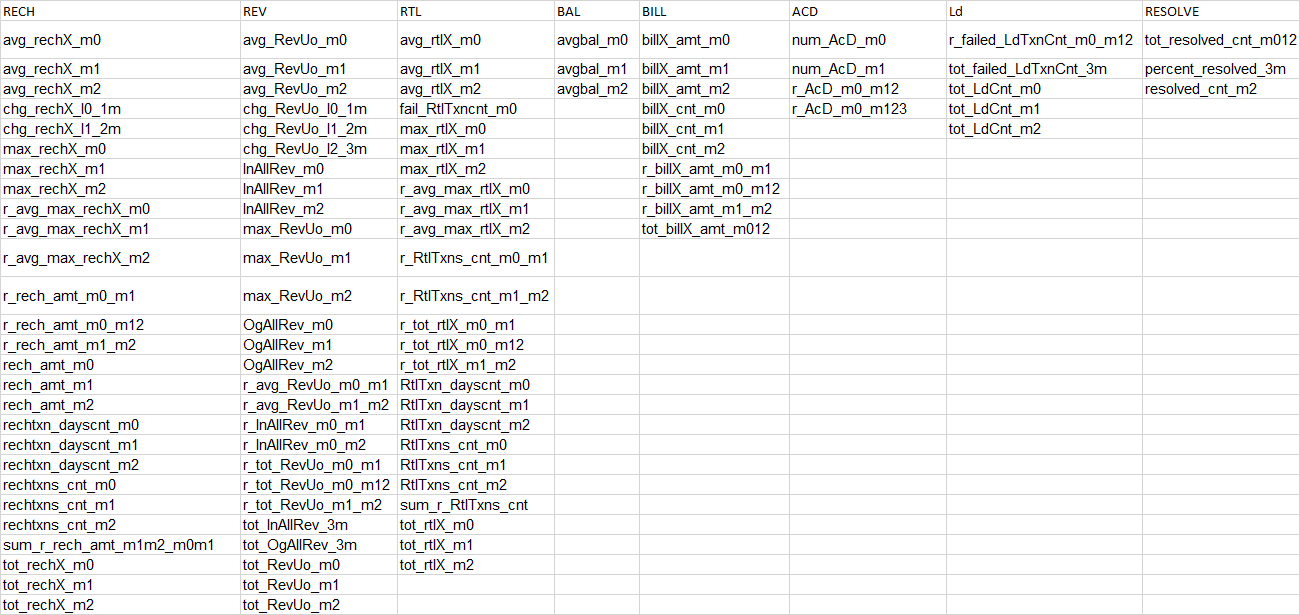

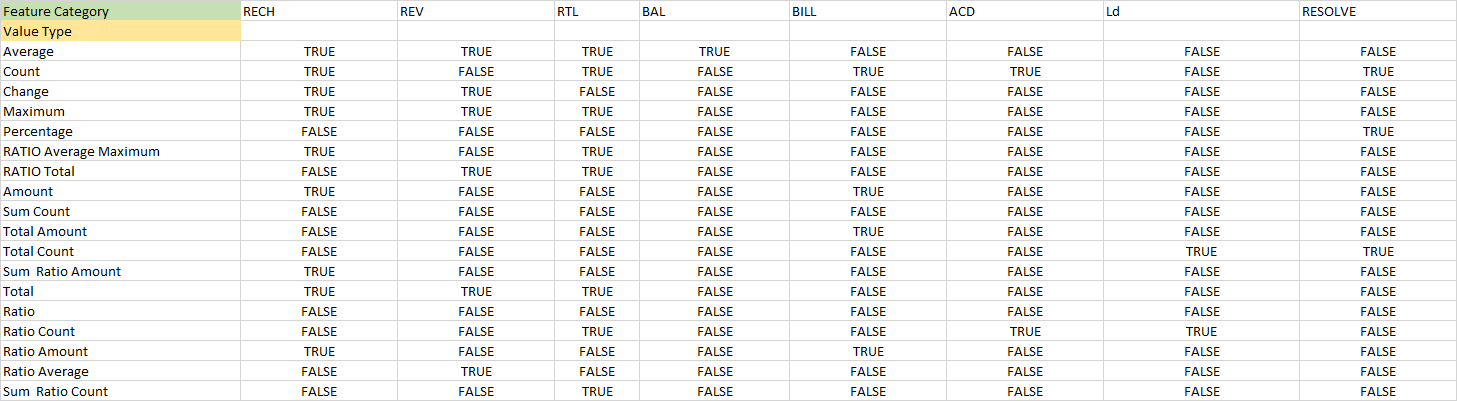

In [ ]:
data.info()

In [ ]:
#preparing pandas profile report for eda and particularly univariate analysis
profile = pandas_profiling.ProfileReport(data, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_file(output_file="angara_eda.html")

In [ ]:
profile

**Most of the features fall under one of  8 categories,identified above in Excel Workbook. Let's inspect columns which are beyond that. **

In [ ]:
inspection_cols =['ActiveSinceDays','avgdays_btw_loads_l6','Contact_ind','Customer_status','dayssincelastload','daystofirstload']

In [ ]:
data[inspection_cols]

In [ ]:
# number of unique values in each column
data[inspection_cols].nunique()

In [ ]:
data.Customer_status.unique()

### Description of Features:
- ActiveSinceDays : values are Days since when user is active on the platform.
- Contact_ind : Indicator whether customer's contact number is available at the platform or not.
- Customer_status : Activity status of the customer.

Rest all features are with respect to load. Don't know exactly what it means w.r.t to transaction, churn, or onboarding either. But let's guess business meaning of the feature beyond loading.  Assuming load means when customer loads its shopping cart.
- avgdays_btw_loads_l6 : Average of number of days for load in 6th month.
- dayssincelastload : Number of days since when the customer did last loading.
- daystofirstload : Number of days since when customer did loading for the first time.

#### Feature Engineering 
- loading_period = daystofirstload - dayssincelastload

#### Remarks
- After glancing through all the varibales, it is evident that these are not the base features (raw faetures). These features have been derived out of the raw data and also, some modeling has already been performed upon it to collate the best features. avgdays_btw_loads_l6 is an example of best feature of model because, none of the other avgdays_btw_loads_* (l1,l2,l3,l4,l5 etc.) is present in data. other exmaples are some of the ratio related features.
- Customers are as old as 8.5 years and the most new customer is 72 days old & on an averge customer is 2 year old. 
- There are 5 classes of activity status defined by the business for a customer.
- Please refer to attaCorrelation details between features as follows -




In [ ]:
#columns with missing values as nan.
data.columns[data.isna().sum()>0]

In [ ]:
missing_val_columns  = ['r_avg_max_rtlX_m0', 'r_avg_max_rtlX_m1', 'r_avg_max_rtlX_m2','r_avg_max_rechX_m0', 'r_avg_max_rechX_m1', 'r_avg_max_rechX_m2']

#### Missing Value Imputation as per already followed pattern = -999. We may use KNN Imputation but that should be done during data preparation.

In [ ]:
data[data.isna()]=-999

In [ ]:
data.columns[data.isna().sum()>0]

Remarks : Missing value is represented as -999

#### Columns to drop due to single value in each row.[](http://)

In [ ]:
drop_Columns = list(data.nunique()[data.nunique()==1].index)

# Bill Amount & Count Analysis

In [ ]:
bill_amount_cols = [i for i in data.columns if i.startswith('billX_amt')]
bill_count_cols = [i for i in data.columns if i.startswith('billX_cnt')]
bill_derived_cols = [i for i in data.columns if (i.startswith('r_bill') or i.startswith('tot_bill'))]


In [ ]:
data[bill_amount_cols+bill_count_cols+bill_derived_cols]


- Feature Engineering : per bill amount in a month, median monthly bill amount, maximum monthly bill amount,satandard deviation in monthly bill amount, total bill bracket, sum of bill counts

In [ ]:
sum(data.tot_billX_amt_m012==0)

In [ ]:
data[data.tot_billX_amt_m012>0][bill_amount_cols+bill_count_cols+bill_derived_cols].describe()

In [ ]:
sum(data[bill_count_cols].apply(lambda x:  sum(x),axis=1)==0)

In [ ]:
data[data.tot_billX_amt_m012>0][bill_amount_cols].plot(kind='line', figsize=(40,8))

The above graph shows some of the outlier values for each column. Let's check outlier values, where outlier is defined as values beyond 99th percentile value of the feature. 

In [ ]:
data[data.tot_billX_amt_m012>0][bill_amount_cols+bill_count_cols+bill_derived_cols].quantile(np.arange(0.95,1,0.01))

In [ ]:
sns.pairplot(data[bill_amount_cols+bill_count_cols+['targetid']],hue='targetid',size=5)

- The diagonal plots of pairplot shows data distribution of each feature for both the target class. Although, the number of data points in churning class is less than non-churning class, leading to data imbalance, the data ditribution in both class still remains same, more or less. Hence, individual features don't have much prediction power with them. 
- The plots on non-diagonal axis captures linear interaction between variables and it is evident that if we have some room for mis-classification, then a decision boundary can be drawn to separate churning and non-churning customers. Thus, we can safely say that, linear interaction of the two varibales possess some prediction power. 

In [ ]:
grid_kws = {"height_ratios": (.9, .03), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(12,12))
ax = sns.heatmap(data[bill_amount_cols+bill_count_cols+bill_derived_cols].corr(), ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})

There is high correlation among these group of variables, as can be read from the scale.

# Balance Analysis

In [ ]:
balance_cols = [i for i in data.columns if i.startswith('avgbal')]

In [ ]:
data[balance_cols].head()

In [ ]:
data[balance_cols].describe()

Feature Engineering : Total Balance over last 3 months, Average balance over last 3 months, Maximum monthly balance , Median monthly Balance, Standard deviation in balance, 

In [ ]:

data[data[balance_cols].apply(lambda x : sum(x),axis=1)>0][balance_cols].plot(kind='line', figsize=(40,8))

The above graph shows some of the outlier values for each column. Let's check outlier values, where outlier is defined as values beyond 99th percentile value of the feature. This is much evident in feature `avgbal_m2`.

In [ ]:
data[data[balance_cols].apply(lambda x : sum(x),axis=1)>0][balance_cols].quantile(np.arange(0.95,1,0.01))

In [ ]:
sns.pairplot(data[data[balance_cols].apply(lambda x : sum(x),axis=1)>0][balance_cols+['targetid']],hue='targetid',size=5)

- The diagonal plots of pairplot shows data distribution of each feature for both the target class. Although, the number of data points in churning class is less than non-churning class, leading to data imbalance, the data ditribution in both class still remains same, more or less (high overlap). Hence, individual features don't have much prediction power with them. 
- The plots on non-diagonal axis captures linear interaction between variables and it is evident that if we have some room for mis-classification, then a decision boundary can be drawn to separate churning and non-churning customers. Thus, we can safely say that, linear interaction of the two varibales possess some prediction power except `avgbal_m1 and avgbal_m2`, where there is significant overlap between two classses of data in the linear interaction.

In [ ]:
grid_kws = {"height_ratios": (.9, .03), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(6,6))
ax = sns.heatmap(data[balance_cols].corr(), ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})

There is high correlation among these group of variables, as can be read from the scale.

# RTL Analysis

In [ ]:
rtl_columns = [i for i in data.columns if re.compile(r'rtl').search(i.lower()) ]

In [ ]:
data[rtl_columns]

- Remark : Ratio of transaction count is calculated after adding 1 in the base.

In [ ]:
data[rtl_columns].describe()

In [ ]:
data[rtl_columns].quantile(np.arange(0.95,1,0.01))

In [ ]:
sns.pairplot(data[rtl_columns+['targetid']],hue='targetid')

#### The pairplot shows that although the individual features don't have much prediction power but the linear interaction of some of the features do have some prediction power.

In [ ]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(40,10))
ax = sns.heatmap(data[rtl_columns].corr(), ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})


There is high correlation among these group of variables, as can be read from the scale.

# RECH Analysis

In [ ]:
rech_columns = [i for i in data.columns if re.compile(r'rech').search(i.lower()) ]

In [ ]:
data[rech_columns]

In [ ]:
data[rech_columns].describe()

In [ ]:
data[rech_columns].quantile(np.arange(0.95,1,0.01))

In [ ]:
sns.pairplot(data[rech_columns+['targetid']],hue='targetid')

#### The pairplot shows that although the individual features don't have much prediction power but the linear interaction of some of the features do have some prediction power.

In [ ]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(40,10))
ax = sns.heatmap(data[rech_columns].corr(), ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})

There is high correlation among these group of variables, as can be read from the scale.

# REV Analysis

In [ ]:
rev_columns = [i for i in data.columns if re.compile(r'rev').search(i.lower()) ]

In [ ]:
data[rev_columns]

In [ ]:
data[rev_columns].describe()

In [ ]:
data[rev_columns].quantile(np.arange(0.95,1,0.01))

In [ ]:
sns.pairplot(data[rev_columns+['targetid']],hue='targetid')

#### The pairplot shows that although the individual features don't have much prediction power but the linear interaction of some of the features do have some prediction power.

In [ ]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(40,10))
ax = sns.heatmap(data[rev_columns].corr(), ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})

There is high correlation among these group of variables, as can be read from the scale.

# ACD, LD & RESOLVE Analysis

In [ ]:
alr_columns =  [i for i in data.columns if re.compile(r'acd').search(i.lower()) or re.compile(r'ld').search(i.lower()) or re.compile(r'resolve').search(i.lower()) ]

In [ ]:
alr_columns

In [ ]:
data[alr_columns]

In [ ]:
data[alr_columns].describe()

In [ ]:
data[alr_columns].quantile(np.arange(0.95,1,0.01))

#### The pairplot shows that although the individual features don't have much prediction power but the linear interaction of some of the features do have some prediction power.

In [ ]:
sns.pairplot(data[alr_columns+['targetid']],hue='targetid')

In [ ]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(40,10))
ax = sns.heatmap(data[rev_columns].corr(), ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})

There is high correlation among these group of variables, as can be read from the scale.

#### We need outlier treatment for more generalised model, if target is not significantly  influenced by outliers. We will be treating 1% thresold (500 data points) for outlier treatment.

### Mirror Image Analysis : Let's see effect of outliers & non-outliers on churning of customer to help us understand whether we need outlier treatment. 

In [ ]:
def outlier_effect(column):
    normal_group = data[data[column]<= data[column].quantile(0.99)]['targetid']
    outlier_group = data[data[column]> data[column].quantile(0.99)]['targetid']
    temp = pd.concat([pd.DataFrame(normal_group.value_counts().values, index=['norm_churn_0', 'norm_churn_1']).apply(lambda x : x*100 / len(normal_group)), pd.DataFrame(outlier_group.value_counts().values,index=['out_churn_0', 'out_churn_1']).apply(lambda x : x*100 / len(outlier_group))])
    temp.columns=[column]
    return temp.T

In [ ]:
outlier_df=pd.DataFrame()
for i in set(data.columns)- set(inspection_cols)-set(missing_val_columns)-set(drop_Columns)-set(['targetid']):
    temp = outlier_effect(i)
    outlier_df=pd.concat([outlier_df,temp])
outlier_df

In [ ]:
outlier_df.plot(kind = 'line', figsize=(24,6));
plt.title('Mirror Image Analyis : Outlier effects of a feature on Target ')

### The mirror image analysis shows that Outliers of every feature have significant influence on the target and hence it would be unwise to perform value capping as outlier treatment. In such scenario, we should choose tree models as our way forward.

# EDA Observations and Next Steps

- We are not goig to do outlier treatment,as outliers defined above(99th percentile) have significant impact on the target class.
- drop the identified columns with constant values.
- we need to go ahead with missinig value imputation.
- Linear interactions of the varibale have significant prediction power.
- But, we can not go ahead with linear models, as that will be highly influenced by outliers in the data.
- we will be using following models as part of pipeline : RandomForest, Xgboost, GradientBoosting, Adaboost,KNN
- Model optimization method used will be :  BayesianOptimization.
- cross validation will be doone using 5 fold cv.
- data imbalance will be handled using class weight parameters of the models.
- we will be using 3 sets of data for training, testing and validation.

#### Evaluation Metrics for model training : ROC-AUC [which tells how much the model has learnt to distinguish between two classes of the target feature]
#### Threshold setting based on : Re-call of Churning Class (1) because we need to pick on all actual churners from the platform.



# Preparing dataset for modeling exercise

In [ ]:
# drop identified columns during eda
def feature_selector_from_raw_data(data,drop_columns):
    if any(pd.Series(data.columns).isin(drop_columns)):
        print('dropping columns : {}'.format(drop_columns))
        X = data.drop(drop_columns,axis=1)
    else:
        X = data
    return X
        

In [ ]:
X = feature_selector_from_raw_data(data,drop_Columns)
X.shape

In [ ]:
# identifying target and identifiers 
target = 'targetid'
identifiers = ['userID']
#  drop from predictor set
identifiers.append(target)


In [ ]:
# segregating predictors and target
X_final = feature_selector_from_raw_data(X,identifiers)
Y_final = data[target]
print('shape of predictor set:',X_final.shape)
print('shape of target:',len(Y_final))

### Preparing Train, Test and Validation set


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final, test_size=0.3,stratify=Y_final)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,stratify=y_test)

In [ ]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print (X_val.shape, y_val.shape)


Missing Value Imputation

In [ ]:
sum([any(X_train[i]==-999) for i in  X_train.columns])

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=-999,strategy='mean'))])

In [ ]:
numeric_features = X_train.columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [ ]:
rf = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
X_train_imputed = rf.fit_transform(X_train)
X_test_imputed = rf.fit_transform(X_test)

### Choose the base classifier for modeling

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
    ]

In [ ]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))
    print("model score: %.3f" % pipe.score(X_train, y_train))


### Looks like XGBoost will work for us.

### Choosing best XGBoost Parameters for model preparation using Bayesian Optimization

In [ ]:
ITERATIONS=5
space={ 'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'n_estimators': (50, 1000),
        'scale_pos_weight': (1e-6, 50, 'log-uniform') }


In [ ]:
# Classifier
bayes_cv_tuner = BayesSearchCV(estimator = xgb.XGBClassifier(n_jobs = 1,objective = 'binary:logistic',
                                                             eval_metric = 'auc',silent=1),search_spaces = space,
                               scoring = 'roc_auc',cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42),
                               n_jobs = -1,n_iter = ITERATIONS,verbose = 0,refit = True,random_state = 42)



In [ ]:
def bayesian_space_status(optim_result):    
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)      
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest AUC : {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [ ]:
# Fit the model
result = bayes_cv_tuner.fit(X_train_imputed, y_train.values, callback=bayesian_space_status)

### Listing optimal parameters for our first version of model

In [ ]:
# optimal_params_0 = {'colsample_bylevel': 0.7366877378057127,
#                   'colsample_bytree': 0.9399760402267441, 
#                   'gamma': 2.6498051478267012e-08,
#                   'learning_rate': 0.0238149998729586,
#                   'max_delta_step': 16,
#                   'max_depth': 19, 
#                   'min_child_weight': 2,
#                   'n_estimators': 764,
#                   'reg_alpha': 0.011683028450342707,
#                   'reg_lambda': 0.0048879464985534336,
#                   'scale_pos_weight': 0.13267482411031659,
#                   'subsample': 0.5689543694097536}
optimal_params = {'colsample_bylevel': 0.8390144719977516, 
                     'colsample_bytree': 0.8844821246070537, 
                     'gamma': 4.358684608480795e-07,
                     'learning_rate': 0.7988179462781242, 
                     'max_delta_step': 17, 
                     'max_depth': 3,
                     'min_child_weight': 1,
                     'n_estimators': 386,
                     'reg_alpha': 0.0005266983003701547,
                     'reg_lambda': 276.5424475574225, 
                     'scale_pos_weight': 0.07072768063383618,
                     'subsample': 0.9923710598637134}
optimal_params['eval_metric'] = 'auc'
optimal_params['n_jobs'] = -1
optimal_params['objective'] = 'binary:logistic'
optimal_params['tree_method'] = 'approx'
optimal_params['verbose'] = 0
optimal_params['importance_type'] = 'gain'
optimal_params['missing'] = -999


In [ ]:
# dtrain = xgb.DMatrix(X_train, label=y_train,missing=-999)
# dtest = xgb.DMatrix(X_test, label=y_test,missing=-999)
# dval = xgb.DMatrix(X_val, label=y_val,missing=-999)
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
# num_round = 200
# bst = xgb.train(optimal_params, dtrain, num_round, watchlist,early_stopping_rounds=20)
#xgb.to_graphviz(bst, num_trees=2)
#plt.rcParams["figure.figsize"] = (15,10)
#xgb.plot_importance(bst, importance_type='gain',max_num_features =25)

Using scikitlearn API of XGBoost for model training using evaluation set for controlling 

In [ ]:
clf = xgb.XGBClassifier(n_estimators = optimal_params['n_estimators'], 
                        max_depth = optimal_params['max_depth'],
                        min_child_weight = optimal_params['min_child_weight'],
                        subsample = optimal_params['subsample'],
                        colsample_bylevel = optimal_params['colsample_bylevel'],
                        gamma = optimal_params['gamma'],
                        colsample_bytree = optimal_params['colsample_bytree'],
                        learning_rate = optimal_params['learning_rate'],
                        max_delta_step = optimal_params['max_delta_step'],
                        reg_alpha = optimal_params['reg_alpha'],
                       reg_lambda = optimal_params['reg_lambda'],
                       scale_pos_weight = optimal_params['scale_pos_weight'],
                       importance_type = optimal_params['importance_type'],
                       missing = optimal_params['missing'],
                       seed=42)

In [ ]:
clf = xgb.XGBModel(**optimal_params)

clf.fit(X_train_imputed, y_train.values,
        eval_set=[(X_train_imputed, y_train.values), (X_test_imputed, y_test.values)],
        eval_metric='auc',
        early_stopping_rounds =20,
        verbose=True)

evals_result = clf.evals_result()

In [ ]:
pd.concat([pd.DataFrame(evals_result['validation_0']),pd.DataFrame(evals_result['validation_1'])], axis=1).plot()

In [ ]:
clf.get_params()

In [ ]:
feature_imp  = pd.DataFrame([X_train.columns,clf.feature_importances_]).T
feature_imp.columns=['predictor','importance']
feature_imp.sort_values('importance',ascending=False)

In [ ]:
pred_train = clf.predict(X_train_imputed)
y_train_pred = np.where(pd.Series(pred_train) > 0.004, 1,0)
pd.DataFrame({'predicted_probabilities':pred_train,'predicted':y_train_pred,'actual':y_train}).to_csv('train_thresold.csv',index= False)
print(classification_report(y_train, y_train_pred))


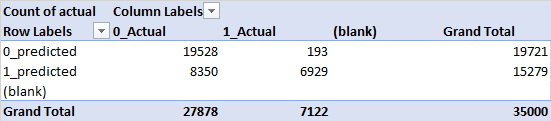
We can identify all customers who are actually churning.

In [ ]:
pred_test = clf.predict(X_test_imputed)
y_test_pred = np.where(pd.Series(pred_test) > 0.004, 1,0)
pd.DataFrame({'predicted_probabilities':pred_test,'predicted':y_test_pred,'actual':y_test}).to_csv('test_thresold.csv',index= False)
print(classification_report(y_test, y_test_pred))


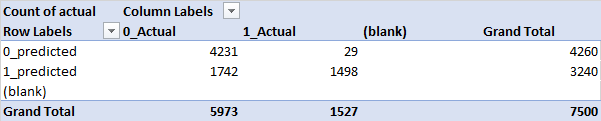

In testing : We are able to identify 1498 out of 1526 churning customers.

# Preparing final model 

In [ ]:
X = np.vstack((X_train_imputed,X_test_imputed))
Y = np.hstack((y_train,y_test))

In [ ]:
clf = xgb.XGBModel(**optimal_params)

clf.fit(X, Y,
        eval_set=[(X,Y)],
        eval_metric='auc',
        early_stopping_rounds =20,
        verbose=True)

evals_result = clf.evals_result()

In [ ]:
# save model 
import pickle
with open('xgboost.pkl','wb') as file:
    pickle.dump(clf,file)
file.close()

In [ ]:
# load model
with open('xgboost.pkl','rb') as file:
    clf = pickle.load(file)
file.close()

## Testing model on completely unseen data

In [ ]:
X_val_imputed = rf.fit_transform(X_val)
pred_val = clf.predict(X_val_imputed)
y_val_pred = np.where(pd.Series(pred_val) > 0.004, 1,0)
pd.DataFrame({'predicted_probabilities':pred_val,'predicted':y_val_pred,'actual':y_val}).to_csv('val_thresold.csv',index= False)
print(classification_report(y_val, y_val_pred))

	

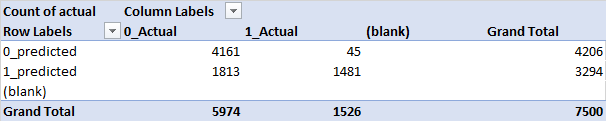

On unseen data : We are able to identify 1481 out of 1526 churning customers.

# Assignment Report

***Next Steps (Please consider this as time crunch,but we can definitely discuss these steps)***

- To capture linear interactions of the variable, we can do feature generation using multiplication operators.
- we have to perform feature engineerinig as identified above.
- we will be going ahead with feature engineering after producing base model.
- we can do the same exercise on larger dataset.
- we can employ shapley values to understand the impact of each of the feature on every data point giving us clear explanation of which factor actual lead to such decision by the model.

***Result Discussion ***

- We will be reporting the results that we got on unseen data. We can not report the result of training or testing data as those were employed for model building and validation. And over the course of model exercise some way or other model tried to mimic the target feature of those datasets.

- Threshold value for the model prediction has been choosen with the consideration that we don't want to miss out on any customer who can churn. And thus has lots of type 2 error. Both type 1 and type 2 error has some cost associated with it. e.g- opportunity cost if churning customer is not identified and cost associated with CRM and operations for non-churning customer. So, we should bring business people onboard to calculate such cost each customer and think of business profitability overall before setting such thresholds.


***Things not done ***
- No statistical test to performed for hypothesis testing because the data provided do not seem to be raw data and are derived features. Also, these features seem to provided after some feature selection or collecting feature importance as discussed above.





# USECASE 2 : CUSTOMER SEGMENTATION

#### We are going ahead with the all variables for customer segmentation for following reasons:

- The 8 categories of variable defined above tells some or other feature of the customer.
e.g- 
            - Bill gives us the indication of purchasing power of the customer.
            - resolve gives us the indication of customer satisfaction.
            - balance gives us the indication of willingnes or intent of customer to continue purchasing etc.
            
- The defined value type like - average, count, ratio of amount /count between months etc., of such categories of variable helps us understand things like frequency of purchase, recency of purchase, wallet share on an average etc.


In [ ]:
X.shape

In [ ]:
X_final.shape

Since we have all the numbers here and some categorical features like customer status and contact indicator have inherent order we can safely go ahead with K-means clsutering and do the cluster profiling later on.

#### Steps to be followed :
- Missing value imputation
- Standard Scaling
- Dimensionality Reduction
- Clustering & related activites
- Cluster Profiling


In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=-999,strategy='mean')),
    ('scaler', StandardScaler())])

numeric_features = X_final.columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

pipe_processor = Pipeline(steps=[('preprocessor', preprocessor)])

X_processed = pipe_processor.fit_transform(X_final)

## Principal Component Analysis

In [ ]:
pca = decomposition.PCA(random_state=42)
pca.fit_transform(X_processed)
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(56, c='b')
plt.axhline(0.95, c='r')
plt.show();

The cummulative explained variance graph tells us if we take first 56 components than these explain 95 percent of the variance in the data.

In [ ]:

for i, component in enumerate(pca.components_[:5]):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    temp = {col: value for col, value in zip(X_final.columns,component)}
    df = pd.DataFrame.from_dict(temp,'index',columns=['feature_projection']).sort_values(by='feature_projection')
    print(df.head(5)),print(df.tail(5))
    

In [ ]:
pca = decomposition.PCA(n_components=56,random_state=42)
X_reduced = pca.fit_transform(X_processed)

In [ ]:
X_reduced.shape

## K-means

In [ ]:
inertia = []
for k in range(1, 40):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_reduced)
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,10))
plt.plot(range(1, 40), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('sum of sqrd dist b/w observations and their centroids');

Number of Cluster segments of customers can be obtained with the help of elbow-curve.
In the following section we used silhouette coefficient to remove the point of contention between 4,5 or 6.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(X_reduced)
print('Silhouette :', metrics.silhouette_score(X_reduced, kmeans.labels_))
kmeans = KMeans(n_clusters=5, random_state=1).fit(X_reduced)
print('Silhouette :', metrics.silhouette_score(X_reduced, kmeans.labels_))
kmeans = KMeans(n_clusters=6, random_state=1).fit(X_reduced)
print('Silhouette :', metrics.silhouette_score(X_reduced, kmeans.labels_))


Greater silhouette coefficient is indicative of better number of clusters.

In [ ]:
kmeans_final = KMeans(n_clusters=4, random_state=1).fit(X_reduced)

In [ ]:
# save model 
import pickle
with open('kmeans_model.pkl','wb') as file:
    pickle.dump(kmeans_final,file)
file.close()

In [ ]:
# load model
with open('kmeans_model.pkl','rb') as file:
      kmeans_final2 = pickle.load(file)


In [ ]:
#kmeans_final.labels_.shape
X_final['labels']=kmeans_final.labels_

## Cluster Profiling

In [ ]:
temp_0 = X_final[X_final['labels']==0].describe().T
temp_0.columns = ['count_0','mean_0','std_0','min_0','25%_0','50%_0','75%_0','max_0']
temp_1 = X_final[X_final['labels']==1].describe().T
temp_1.columns = ['count_1','mean_1','std_1','min_1','25%_1','50%_1','75%_1','max_1']
temp_2 = X_final[X_final['labels']==2].describe().T
temp_2.columns = ['count_2','mean_2','std_2','min_2','25%_2','50%_2','75%_2','max_2']
temp_3 = X_final[X_final['labels']==3].describe().T
temp_3.columns = ['count_3','mean_3','std_3','min_3','25%_3','50%_3','75%_3','max_3']

In [ ]:
profile_data = pd.concat([temp_0,temp_1,temp_2,temp_3],axis=1)

In [ ]:
profile_data.loc[bill_amount_cols,['mean_0','mean_1','mean_2','mean_3']].plot(kind='barh', )

In [ ]:
profile_data.loc[bill_count_cols,['mean_0','mean_1','mean_2','mean_3']].plot(kind='barh', )

In [ ]:
profile_data.loc[bill_derived_cols,['mean_0','mean_1','mean_2','mean_3']].plot(kind='barh', )

In [ ]:
profile_data.loc[rech_columns,['mean_0','mean_1','mean_2','mean_3']].plot(kind='barh',figsize=(10,10) )

In [ ]:
profile_data.loc[rev_columns,['mean_0','mean_1','mean_2','mean_3']].plot(kind='barh',figsize=(10,10) )

In [ ]:
profile_data.loc[rtl_columns,['mean_0','mean_1','mean_2','mean_3']].plot(kind='barh',figsize=(10,10) )

In [ ]:
profile_data.loc[balance_cols,['mean_0','mean_1','mean_2','mean_3']].plot(kind='barh' )

In [ ]:
profile_data.loc[alr_columns,['mean_0','mean_1','mean_2','mean_3']].plot(kind='barh',figsize=(10,10) )

The graphs above tell us the very distinct nature of cluster 1 .

- Cluster 3 : Customers whose total rtl spend over each month is maximum.
- Cluster 1:  customers whose total spend pertaining to bill, rech over the whole month is maximum.They are the customers who average is also maximum. And this is a small group of customers who should be catered well because they are huge cash cow for the business.
- Clusters 0 : Customers falling in this clusters can be easily pleased when they have some issue, relative to customers of other clusters.
- Cluster 2 : This is  80% of the customers who give you 20 % of the business. 


If you want to build segments based on profitability alone, we should choose features that only pertain to profitability and not confuse the model with  other features.